<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/%5B20250315%5D%20Thesis%20work%20hubrid%20RF-LSTM%20on%20WSN-DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

On WSN-DS (5 Classes)

In [1]:
#Imports various Python libraries necessary
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils import np_utils
#from keras.utils import np_utils
#from tensorflow.keras import np_utils
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification

In [2]:
# Load dataset
dataset = pd.read_csv("dataset_WSN-DS.csv")

# Preprocessing: Handle missing values (if any)
dataset = dataset.dropna() # Remove missing values

In [3]:
dataset

,id,Time,Is_CH,who CH,Dist_To_CH,ADV_S,ADV_R,JOIN_S,JOIN_R,SCH_S,SCH_R,Rank,DATA_S,DATA_R,Data_Sent_To_BS,dist_CH_To_BS,send_code,Expaned Energy,Class
0,101000,50,1,101000,0.00000,1,0,0,25,1,0,0,0,1200,48,130.08535,0,2.46940,0
1,101001,50,0,101044,75.32345,0,4,1,0,0,1,2,38,0,0,0.00000,4,0.06957,0
2,101002,50,0,101010,46.95453,0,4,1,0,0,1,19,41,0,0,0.00000,3,0.06898,0
3,101003,50,0,101044,64.85231,0,4,1,0,0,1,16,38,0,0,0.00000,4,0.06673,0
4,101004,50,0,101010,4.83341,0,4,1,0,0,1,25,41,0,0,0.00000,3,0.06534,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374656,201096,1003,0,201051,6.98337,0,5,1,0,0,1,7,96,0,67,170.14779,3,0.15974,0
374657,201097,1003,0,201037,29.32867,0,5,1,0,0,1,31,39,0,24,82.21043,2,0.06877,0
374658,201098,1003,0,201095,18.51963,0,5,1,0,0,1,17,55,0,31,139.26438,1,0.09437,0
374659,201099,1003,0,201051,8.55001,0,5,1,0,0,1,3,96,0,65,158.27492,3,0.16047,0


In [4]:
# Encode non-numeric columns (if any)
for column in dataset.columns:
    if dataset[column].dtype == 'object':  # Identify categorical columns
        dataset[column] = LabelEncoder().fit_transform(dataset[column])

# Separate features (X) and target (y)
X = dataset.drop(['Class'], axis=1)  # Assuming 'Class' is the target column
y = dataset['Class']

print("Original Class Distribution:", np.bincount(y))

Original Class Distribution: [340066  14596  10049   6638   3312]


In [5]:
from sklearn.preprocessing import LabelEncoder, StandardScaler # Import StandardScaler here
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [6]:
!pip install -U imbalanced-learn

In [7]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the data
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Verify the balanced dataset distribution
print("Balanced Class Distribution:", np.bincount(y))

Balanced Class Distribution: [340066 340066 340066 340066 340066]


In [8]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)

In [9]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, TimeDistributed
from tensorflow.keras.regularizers import l2
import numpy as np

In [10]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, TimeDistributed
from tensorflow.keras.regularizers import l2
import numpy as np

# Train RF model
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)

# Extract features from RF model
train_rf_features = rf_model.predict(X_train)
test_rf_features = rf_model.predict(X_test)

# Reshape RF features for LSTM input - Adding a new axis to create a 2D array before reshaping
train_rf_features = train_rf_features[:, np.newaxis]  # Reshape to (n_samples, 1)
test_rf_features = test_rf_features[:, np.newaxis]    # Reshape to (n_samples, 1)

# Reshape for LSTM input - Using the correct shape for 3D input
train_rf_features = np.reshape(train_rf_features, (train_rf_features.shape[0], 1, train_rf_features.shape[1]))
test_rf_features = np.reshape(test_rf_features, (test_rf_features.shape[0], 1, test_rf_features.shape[1]))

In [11]:
# Train LSTM model with RF features
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(1, train_rf_features.shape[2]), return_sequences=True, kernel_regularizer=l2(0.0001)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(32, return_sequences=True, kernel_regularizer=l2(0.0001)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(16, kernel_regularizer=l2(0.0001)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(5, activation='softmax'))

lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Convert y_train and y_test to one-hot encoded format
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=5)  # Assuming you have 4 classes
y_test = to_categorical(y_test, num_classes=5)
history = lstm_model.fit(train_rf_features, y_train, epochs=50, batch_size=64, validation_split=0.2)

# Evaluate hybrid model on test set
test_lstm_features = lstm_model.predict(test_rf_features)
test_rf_lstm_predictions = np.argmax(test_lstm_features, axis=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
17004/17004 ━━━━━━━━━━━━━━━━━━━━ 127s 7ms/step - accuracy: 0.9615 - loss: 0.1326 - val_accuracy: 1.0000 - val_loss: 0.0040
Epoch 2/50
17004/17004 ━━━━━━━━━━━━━━━━━━━━ 142s 7ms/step - accuracy: 0.9998 - loss: 0.0053 - val_accuracy: 1.0000 - val_loss: 0.0034
Epoch 3/50
17004/17004 ━━━━━━━━━━━━━━━━━━━━ 126s 7ms/step - accuracy: 0.9998 - loss: 0.0041 - val_accuracy: 1.0000 - val_loss: 0.0032
Epoch 4/50
17004/17004 ━━━━━━━━━━━━━━━━━━━━ 140s 7ms/step - accuracy: 0.9998 - loss: 0.0038 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 5/50
17004/17004 ━━━━━━━━━━━━━━━━━━━━ 129s 8ms/step - accuracy: 0.9998 - loss: 0.0037 - val_accuracy: 1.0000 - val_loss: 0.0032
Epoch 6/50
17004/17004 ━━━━━━━━━━━━━━━━━━━━ 116s 7ms/step - accuracy: 0.9998 - loss: 0.0035 - val_accuracy: 1.0000 - val_loss: 0.0028
Epoch 7/50
17004/17004 ━━━━━━━━━━━━━━━━━━━━ 158s 8ms/step - accuracy: 0.9998 - loss: 0.0034 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 8/50
17004/17004 ━━━━━━━━━━━━━━━━━━━━ 129s 8ms/step - ac

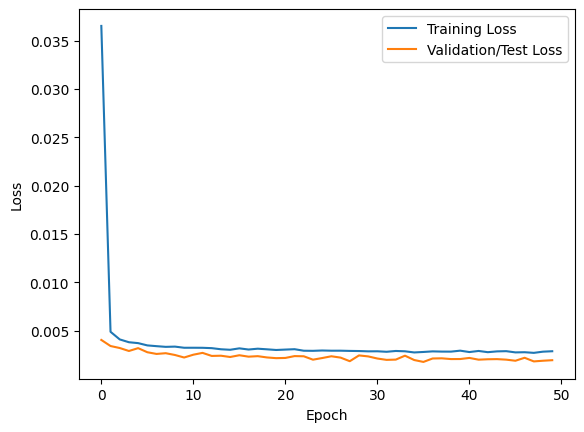

In [12]:
# Plot training/validation loss over each epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation/Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
# Calculate evaluation metrics
accuracy = accuracy_score(np.argmax(y_test, axis=1), test_rf_lstm_predictions)
recall = recall_score(np.argmax(y_test, axis=1), test_rf_lstm_predictions, average='weighted')
precision = precision_score(np.argmax(y_test, axis=1), test_rf_lstm_predictions, average='weighted')
f1score = f1_score(np.argmax(y_test, axis=1), test_rf_lstm_predictions, average='weighted')
confusion_mat = confusion_matrix(np.argmax(y_test, axis=1), test_rf_lstm_predictions)
classification_rep = classification_report(np.argmax(y_test, axis=1), test_rf_lstm_predictions)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-Score:", f1score)
print("Confusion Matrix:\n", confusion_mat)
print("Classification Report:\n", classification_rep)

Accuracy: 0.9991619273905653
Recall: 0.9991619273905653
Precision: 0.999161861027029
F1-Score: 0.999161783397902
Confusion Matrix:
 [[67866    48     1    41    57]
 [    1 67988    24     0     0]
 [    0    10 68003     0     0]
 [  100     0     2 67912     0]
 [    1     0     0     0 68012]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     68013
           1       1.00      1.00      1.00     68013
           2       1.00      1.00      1.00     68013
           3       1.00      1.00      1.00     68014
           4       1.00      1.00      1.00     68013

    accuracy                           1.00    340066
   macro avg       1.00      1.00      1.00    340066
weighted avg       1.00      1.00      1.00    340066



In [ ]:
# prompt: Display confusion matrix in heatmap

import seaborn as sns

# Assuming 'confusion_mat' is your confusion matrix from the previous code

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="bone",
            xticklabels=['Normal','Blackhole','Flooding','Grayhole','TDMA'],
            yticklabels=['Normal','Blackhole','Flooding','Grayhole','TDMA'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Heatmap")
plt.show()

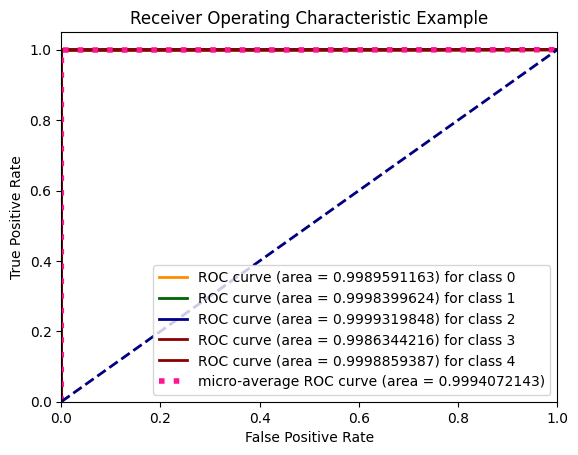

AUC Score for class 0: 0.9989591163292916
AUC Score for class 1: 0.9998399624393625
AUC Score for class 2: 0.9999319847629572
AUC Score for class 3: 0.9986344215669416
AUC Score for class 4: 0.9998859387422128
Micro-average AUC Score: 0.9994072142943741


In [15]:
# prompt: Display AUC and ROC curves with also show micro avg.

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the output
y_test_bin = label_binarize(np.argmax(y_test, axis=1), classes=[0, 1, 2, 3, 4])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], test_lstm_features[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), test_lstm_features.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for the multiclass problem
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.10f) for class 0' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='darkgreen',
         lw=lw, label='ROC curve (area = %0.10f) for class 1' % roc_auc[1])
plt.plot(fpr[2], tpr[2], color='darkblue',
         lw=lw, label='ROC curve (area = %0.10f) for class 2' % roc_auc[2])
plt.plot(fpr[3], tpr[3], color='darkred',
         lw=lw, label='ROC curve (area = %0.10f) for class 3' % roc_auc[3])
plt.plot(fpr[4], tpr[4], color='darkred',
         lw=lw, label='ROC curve (area = %0.10f) for class 4' % roc_auc[4])

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.10f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Example')
plt.legend(loc="lower right")
plt.show()

# Print AUC scores for each class and the micro average
print("AUC Score for class 0:", roc_auc[0])
print("AUC Score for class 1:", roc_auc[1])
print("AUC Score for class 2:", roc_auc[2])
print("AUC Score for class 3:", roc_auc[3])
print("AUC Score for class 4:", roc_auc[4])
print("Micro-average AUC Score:", roc_auc["micro"])

In [16]:
# prompt: Display detection rates in each class

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Assuming 'confusion_mat' is your confusion matrix from the previous code
# and test_lstm_features and y_test are available

# ... (Your existing code)

# Binarize the output
y_test_bin = label_binarize(np.argmax(y_test, axis=1), classes=[0, 1, 2, 3, 4])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], test_lstm_features[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(f"Detection Rate for Class {i}: {roc_auc[i]}")

Detection Rate for Class 0: 0.9989591163292916
Detection Rate for Class 1: 0.9998399624393625
Detection Rate for Class 2: 0.9999319847629572
Detection Rate for Class 3: 0.9986344215669416
Detection Rate for Class 4: 0.9998859387422128


In [ ]:
# prompt: Display confusion matrix in heatmap

import seaborn as sns

# Assuming 'confusion_mat' is your confusion matrix from the previous code

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="bone",
            xticklabels=['Normal','Blackhole','Flooding','Grayhole','TDMA'],
            yticklabels=['Normal','Blackhole','Flooding','Grayhole','TDMA'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Heatmap")
plt.show()